In [1]:
# size dist plus growth rates
import numpy as np

import matplotlib.pyplot as plt
import seaborn
% matplotlib inline
from scipy.stats import norm
from scipy.stats import pareto

import pandas as pd

from scipy.special import erf

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Empirical number of agents and total value
Recommendation: 

1e5 agents. 

~1e11.5 EUR annually 

In [2]:
#eg levels = (np.arange(Q)/Q)[::2]

def plot_levels_reflex(levels, ax):
    for level in levels:
        ax.axhline(level, lw = .4, c = 'k', alpha = .5)
        ax.axvline(level, lw = .4, c = 'k')
        ax.fill_between([0, 1], [0, 1], color = 'w', zorder = 10)
        ax.set_xlim(-0.12, 1)
        ax.set_ylim(0, 1)
        plt.axis('off')
    # ax.plot(levels, levels, '+', markersize = 15, c = '.5')
    ax.plot(levels, len(levels)*[.98], '^', markersize = 8, c = '.5')
    
    # Now we can have the n(Q, q)
def get_n(x1, Q):
    x_lin = np.power(10, x1)
    bins = pd.cut(pd.Series(np.cumsum(x_lin)), Q)
    ns = bins.value_counts().values
    return bins, ns

In [3]:
import seaborn as sns
pal = sns.color_palette('tab10')
pal.as_hex()

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

## Empirical GR

In [5]:
# ## List the datasets for quicker access

# rows = []
# for sizes in ['pareto', 'logn90', 'logn']:
#     cols = []
#     for k, dist in enumerate(['sbtn', 'lapl', 'norm']):        
#         filename = './../../data/processed/exp_var_'+dist+'_1s_'+sizes+'.csv'
#         data = pd.read_csv(filename)
#         cols += [data]
#     rows += [cols]
# data = rows

# # data:
# #         sbtn , lapl, norm
# # pareto
# # logn90
# # logn

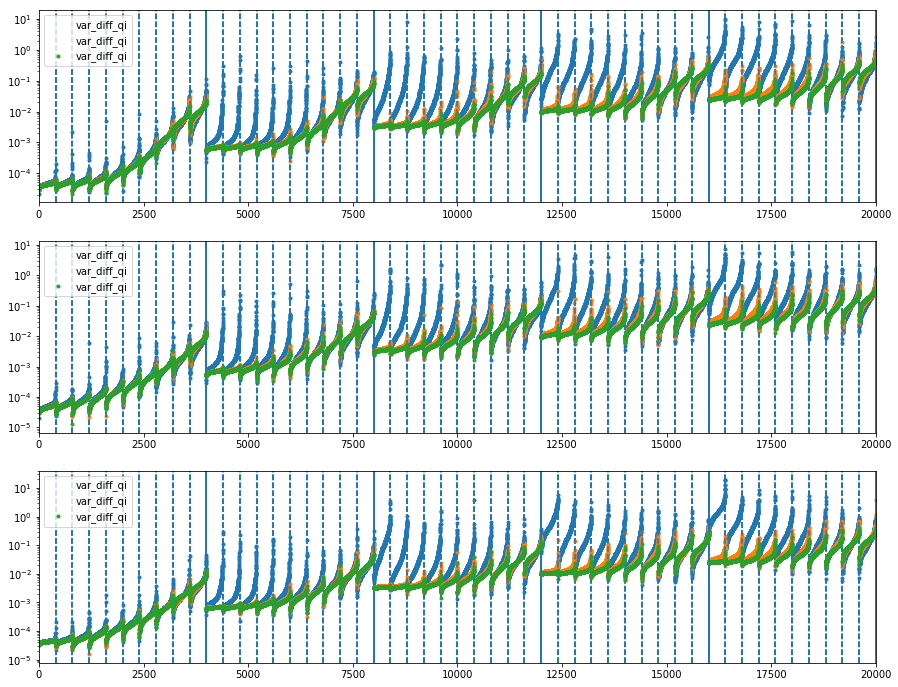

In [7]:
# # In this one, all points go one after the other..
# fig, axs = plt.subplots(3, figsize = (15, 12))

# for i, sizes in enumerate(['pareto', 'logn90', 'logn']):
#     for j, dist in enumerate(['sbtn', 'lapl', 'norm']):
#         ax = axs[i]
#         result = data[i][j]
#         result = result.loc[result.Q == 10]
        
# #         result['t'] = result['var_diff_qi']/(result['s']**2)
#         y = 'var_diff_qi'
#         sorted_ = result.sort_values(by = ['dist','s', 'q', y])
#         [ax.axvline(l, linestyle = '--') for l in sorted_.groupby(['dist','s', 'q']).count().iloc[:, 0].cumsum().values]
#         [ax.axvline(l, lw = 2) for l in sorted_.groupby(['s','Q']).count().iloc[:, 0].cumsum().values]
#         sorted_.reset_index()[[y]].plot(ax = ax, marker = '.', lw = 0, label = sizes)
# #         sorted_.reset_index()[['var_diff_agg_i']].plot(ax = ax, marker = '.', lw = 0, c = '.5', alpha = .1, legend = False)
#         ax.set_yscale('log')


## Quantile volatilities and aggregate

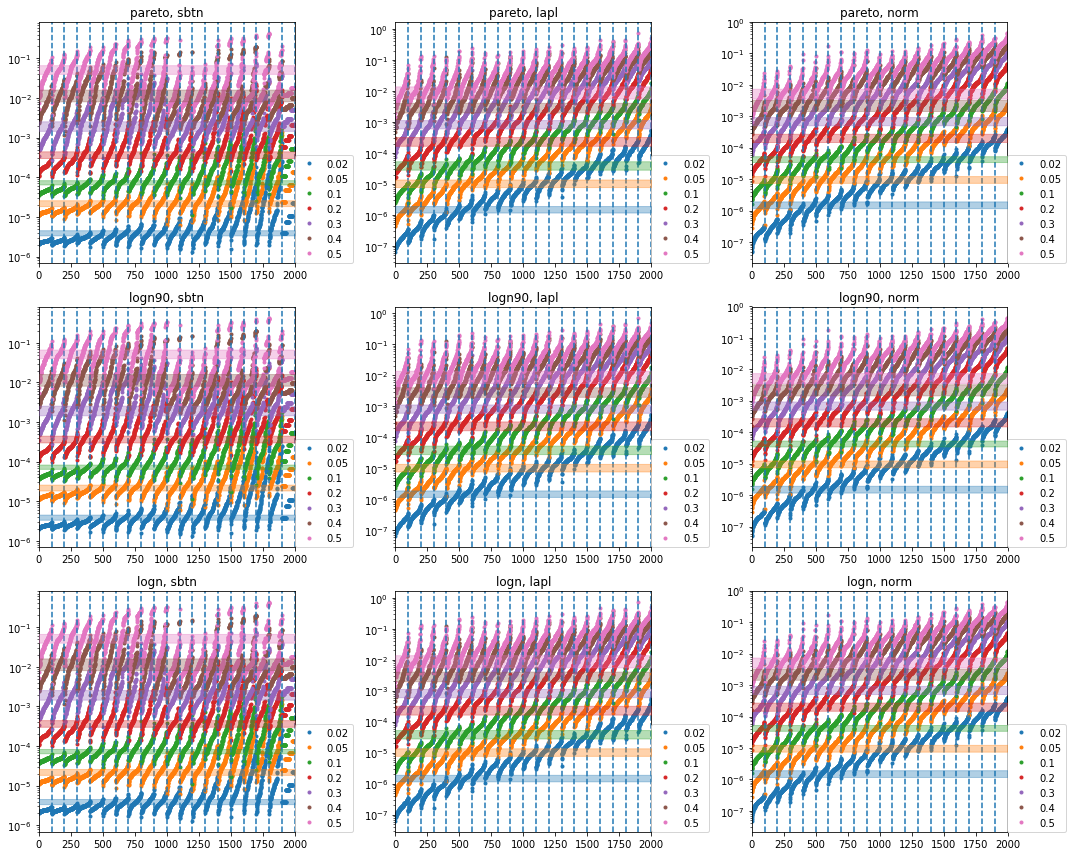

In [268]:
# fig, axs = plt.subplots(3, 3, figsize = (15, 12))

    
# for i, sizes in enumerate(['pareto', 'logn90', 'logn']):
#     for j, dist in enumerate(['sbtn', 'lapl', 'norm']):
#         ax = axs[i][j]
#         ax.set_title(sizes +', '+ dist)
#         result = data3[i][j]
#         result = result.loc[result.Q == 20]

#         y = 'var_diff_qi'
#         sorted_ = result.sort_values(by = ['dist','s', 'q', y])
#         for k, s in enumerate(sorted_.s.unique()):
#             sorted_s = sorted_.loc[sorted_.s == s]
#             sorted_s.reset_index()[[y]].plot(ax = ax, marker = '.', lw = 0, c = colors[k])
# #                     sorted_s.reset_index()[['var_diff_agg_i']].plot(ax = ax, marker = '.', lw = 0, c = colors[k], alpha = .1, legend = False)
#             agg_vals = sorted_s.reset_index()['var_diff_agg_i'].describe()
#             ax.fill_between(range(len(sorted_s)), agg_vals['25%'], agg_vals['75%'], color = colors[k], alpha = .35, zorder = 10)

#         ax.legend(sorted_.s.unique(), loc = (1, 0))
#         [ax.axvline(l, linestyle = '--') for l in sorted_s.groupby(['q']).count().iloc[:, 0].cumsum().values]
#         ax.set_yscale('log')

# plt.tight_layout()


## Bring in the empiricals

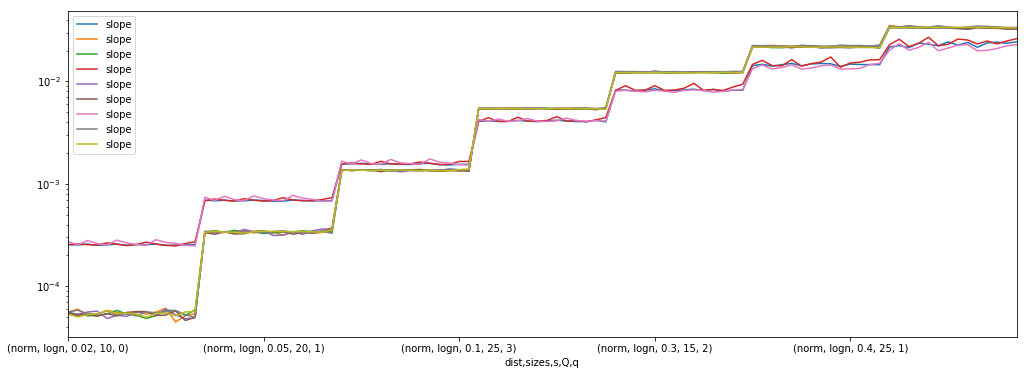

In [90]:
## Check slopes because of bias in log when growth rates diffuse.
# Conclusion: slope given by grs ('dist') and s 

# fig, ax = plt.subplots(1, figsize = (17, 6))

# for j, sizes in enumerate(['pareto', 'logn90', 'logn']):
#     for k, dist in enumerate(['emp_szd_T16', 'lapl', 'norm']):  
#         if k < 10:
#             df = data2[j][k]
#             df['pct'] = (df['q'] + .5)/df['Q']
#             df = df.loc[df.pct < .2]

#             linear_bias = df.groupby(['dist', 'sizes', 's', 'Q', 'q'])[[str(t) for t in range(T + 1)]].apply(lambda x: np.log10(x).mean().diff()).dropna(axis = 1)

#             linear_bias.columns = linear_bias.columns.astype(int)
#             slopes = linear_bias.T.apply(lambda x: np.polyfit(linear_bias.columns, x, 1)[0])

#             pd.DataFrame(abs(slopes), columns = ['slope']).plot(ax = ax)
#             ax.legend(sizes+', '+dist)

# plt.legend()
# plt.yscale('log')
# plt.show()

## Load simulated data

In [4]:
## List the datasets for quicker access

T = 15

rows = []
for sizes in ['pareto', 'logn90', 'logn']:
    cols = []
    for k, dist in enumerate(['sbtn','emp_szd_T16_clip.8','emp_szd_T16', 'lapl', 'norm']):        

        if dist == 'emp_szd_T16_clip.8':
            df = pd.read_csv('./../../data/processed/exp_var_'+dist+'_1s_'+sizes+'_7s_70Qqs_200i_.csv')
            
        else:
            df1 = pd.read_csv('./../../data/processed/exp_var_'+dist+'_1s_'+sizes+'_5s_70Qqs_200i_.csv')
            df2 = pd.read_csv('./../../data/processed/exp_var_'+dist+'_1s_'+sizes+'_2s_70Qqs_200i_.csv')

            if dist == 'emp_szd_T16':
                df2['var_diff_qi'] = np.log10(df2[[str(t) for t in range(T)]]).diff(axis = 1).var(axis = 1) #fix previous problem
            df = pd.concat([df1, df2])
        
        I = df['i'].max() + 1; keep = int(.5*I)    
        ### 
        # DROP CASES WHERE QUANTILES ARE FAR FROM BALANCED
        ###
        df = df.reset_index().set_index(['s','Q', 'q', 'i'])
        df_lin_vals = df[[str(t) for t in range(T + 1)]]
        grouped = df_lin_vals.mean(1).groupby(level = [0, 1, 3]) 
        acceptables = (np.log10(grouped.max()) - np.log10(grouped.min())).groupby(level = [0, 1]).nsmallest(keep).sort_index()
        acceptables.index = acceptables.index.droplevel([0, 1])
        df = df.reset_index().set_index(['s', 'Q', 'i']).loc[acceptables.index].reset_index()#.set_index(['Q', 's', 'i'])
        table = df
            
            
#         table = pd.read_csv(filename)
        cols += [table]
    rows += [cols]
data2 = rows

# data:
#         sbtn , lapl, norm
# pareto
# logn90
# logn


KeyboardInterrupt: 

In [ ]:
### Concatenate if wanted

# T = 15

# df_list = []
# for j, sizes in enumerate(['pareto', 'logn90', 'logn']):
#     for k, dist in enumerate(['emp_szd_T16_clip.8','emp_szd_T16', 'lapl', 'norm', 'sbtn']):  
#         df_list += [data2[j][k]]
# data3 = pd.concat(df_list)

## Estimate bias

In [ ]:
df = data3.copy()
df['pct'] = (df['q'] + .5)/df['Q']
df = df.loc[df.pct < .2]

linear_bias = df.groupby(['dist', 'sizes', 's', 'Q', 'q'])[[str(t) for t in range(T + 1)]].apply(lambda x: np.log10(x).mean().diff()).dropna(axis = 1)

linear_bias.columns = linear_bias.columns.astype(int)
slopes = linear_bias.T.apply(lambda x: np.polyfit(linear_bias.columns, x, 1)[0])
slopes = pd.DataFrame(abs(slopes), columns = ['slope'])

# df['empirical'] = df.index.get_level_values('dist') == 'emp_szd_T16'

slopes = slopes.reset_index()
# slopes['empirical'] = slopes['dist'] == 'emp_szd_T16'
bias_slope = slopes.groupby(['sizes','dist', 's'])['slope'].mean().reset_index()
bias_slope['s2'] = bias_slope['s']**2

fig, ax = plt.subplots(1, figsize = (7, 5))
# for i in [0, 1]:
#     part = bias_slope.loc[bias_slope.empirical == i]

for dist in bias_slope.dist.unique():
    print(dist)
    part = bias_slope.loc[bias_slope.dist == dist]
    part.plot(x = 's2', y = 'slope', ax = ax, marker = '.')
    print(np.polyfit(part.s2, part.slope,1))

## Subtract bias in time series

In [ ]:
df_list = []

size_distributions = ['pareto', 'logn90', 'logn']
growth_rates = ['emp_szd_T16_clip.8','emp_szd_T16', 'lapl', 'norm', 'sbtn']
        
rows = []
for i, sizes in enumerate(size_distributions):
    cols = []        
    for j, dist in enumerate(growth_rates):
        df = data2[i][j]
        
        ## Slopes
        if dist == 'emp_szd_T16': df['slope'] = 0.0896*df['s']**2
        elif dist == 'emp_szd_T16_clip.8': df['slope'] = 0.2236*df['s']**2
        elif dist == 'sbtn': df['slope'] = 0.1096*df['s']**2
        else: df['slope'] = 0.136*df['s']**2

            
        ## qi level
        diff = np.log10(df[[str(t) for t in range(T + 1)]]).diff(axis = 1)
        bias = pd.DataFrame(np.array((T + 1)*[-df['slope'].values]).T*range(T + 1))
        bias.columns = diff.columns
        df['var_diff_qi'] = (diff - bias).var(1) # in place of diff.var(1)
        
        ## i experiment level
        grouped = df.groupby(['dist', 'sizes', 's', 'Q', 'i'])
        diff_agg = grouped[[str(t) for t in range(T + 1)]].apply(lambda x: np.log10(x.sum()).diff())#.tail(20).T.plot(legend = False)
        bias_agg = pd.DataFrame(np.array((T + 1)*[-grouped['slope'].first().values]).T*range(T + 1))
        bias_agg.columns = diff_agg.columns
        bias_agg.index = diff_agg.index
        df_agg = (diff_agg - bias_agg).var(1)
        df_agg.name = 'var_diff_agg_i'

        df = df.drop('var_diff_agg_i', axis = 1)
        df = df.merge(df_agg.reset_index())
#         agg var oneliner: result.groupby(['dist', 'sizes', 's', 'Q', 'i'])[[str(t) for t in range(T + 1)]].apply(lambda x: np.log10(x.sum()).diff().var())
#         df_list += [df]
# data3 = pd.concat(df_list)

        cols += [df]
    rows += [cols]
data3 = rows

# plt.plot(a.values, b.values)

In [11]:
full_data = pd.concat(list(np.array(data3).flatten()))

In [13]:
full_data.to_csv('./../../data/processed/full_data_qi_var.csv', index = False)

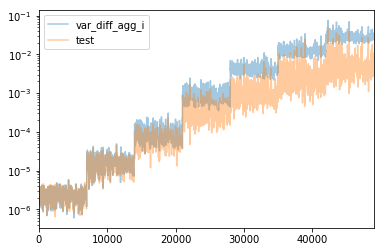

In [260]:
# out[['var_diff_agg_i', 'test']].plot(alpha = .4)
# plt.yscale('log')

## Now, do plots!

In [5]:
full_data = pd.read_csv('./../../data/processed/full_data_qi_var.csv')

In [6]:
import seaborn as sns
pal = sns.color_palette('tab10')
colors = pal.as_hex()

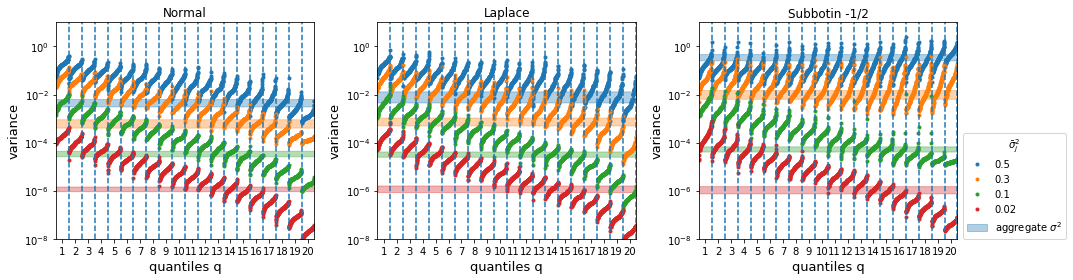

In [19]:
size_distributions = ['logn']
growth_rates = ['norm', 'lapl', 'sbtn']

fig, axs = plt.subplots(len(size_distributions), len(growth_rates), figsize = (5*len(growth_rates), 4*len(size_distributions)))
        
Q = 20
for i, sizes in enumerate(size_distributions):
    for j, dist in enumerate(growth_rates):
        ax = axs[j]
        ax.set_title(['Normal', 'Laplace', 'Subbotin -1/2', 'Empirical, clipped at .8', 'Empirical'][j])
        result = full_data.loc[(full_data.sizes == sizes) & (full_data.dist == dist)]
        result = result.loc[result.Q == Q]

        y = 'var_diff_qi'
        sorted_ = result.sort_values(by = ['dist','s', 'q', y], ascending = [True, False, False, True])
        Ss = sorted_.s.unique()[::2]
        for k, s in enumerate(Ss):
            sorted_s = sorted_.loc[sorted_.s == s]
            sorted_s.reset_index()[[y]].plot(ax = ax, marker = '.', lw = 0, c = colors[k])
#                     sorted_s.reset_index()[['var_diff_agg_i']].plot(ax = ax, marker = '.', lw = 0, c = colors[k], alpha = .1, legend = False)
            agg_vals = sorted_s.reset_index()['var_diff_agg_i'].describe()
            ax.fill_between(range(len(sorted_s)), agg_vals['25%'], agg_vals['75%'], color = colors[k], alpha = .35, zorder = -1)
        
            ax.xaxis.set_ticks(np.arange(0, (Q)*100, 100) + 100/2)
            ax.xaxis.set_ticklabels(np.arange(Q) + 1)

            if j == 2: 
                ax.legend([s for s in Ss]+[r'aggregate $\sigma^2$'], title=r'$\bar \sigma^2_j$', loc = (1.02, 0))
            else:
                ax.get_legend().remove()
#             legend = plt.legend(handles=[one, two, three], title="title", loc=4, fontsize='small', fancybox=True)
            
        [ax.axvline(l, linestyle = '--') for l in sorted_s.groupby(['q']).count().iloc[:, 0].cumsum().values]
        ax.set_yscale('log')
        ax.set_ylim(1e-8, 1e1)
        ax.set_ylabel('variance', fontsize = 13)
        ax.set_xlabel('quantiles q', fontsize = 13)

plt.tight_layout()
plt.savefig('./../../../thesis_writing/figures/quantile_depce_iid.png', dpi = 400)

plt.show()

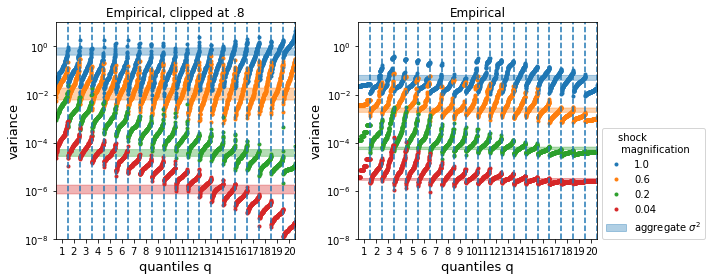

In [23]:
size_distributions = ['logn']
growth_rates = ['emp_szd_T16_clip.8', 'emp_szd_T16']

fig, axs = plt.subplots(len(size_distributions), len(growth_rates), figsize = (5*len(growth_rates), 4*len(size_distributions)))
        
Q = 20
for i, sizes in enumerate(size_distributions):
    for j, dist in enumerate(growth_rates):
        ax = axs[j]
        ax.set_title(['Empirical, clipped at .8', 'Empirical'][j])
        result = full_data.loc[(full_data.sizes == sizes) & (full_data.dist == dist)]
        result = result.loc[result.Q == Q]

        y = 'var_diff_qi'
        sorted_ = result.sort_values(by = ['dist','s', 'q', y], ascending = [True, False, False, True])
        Ss = sorted_.s.unique()[::2]
        for k, s in enumerate(Ss):
            sorted_s = sorted_.loc[sorted_.s == s]
            sorted_s.reset_index()[[y]].plot(ax = ax, marker = '.', lw = 0, c = colors[k])
#                     sorted_s.reset_index()[['var_diff_agg_i']].plot(ax = ax, marker = '.', lw = 0, c = colors[k], alpha = .1, legend = False)
            agg_vals = sorted_s.reset_index()['var_diff_agg_i'].describe()
            ax.fill_between(range(len(sorted_s)), agg_vals['25%'], agg_vals['75%'], color = colors[k], alpha = .35, zorder = -1)
        
            ax.xaxis.set_ticks(np.arange(0, (Q)*100, 100) + 100/2)
            ax.xaxis.set_ticklabels(np.arange(Q) + 1)
            if j == 1: 
                ax.legend([str(2*s) for s in Ss]+[r'aggregate $\sigma^2$'], title='shock \n magnification', loc = (1.02, 0))
            else:
                ax.get_legend().remove()
            
#             legend = plt.legend(handles=[one, two, three], title="title", loc=4, fontsize='small', fancybox=True)
            
        [ax.axvline(l, linestyle = '--') for l in sorted_s.groupby(['q']).count().iloc[:, 0].cumsum().values]
        ax.set_yscale('log')
        ax.set_ylabel('variance', fontsize = 13)
        ax.set_xlabel('quantiles q', fontsize = 13)
        ax.set_ylim(1e-8, 1e1)


plt.tight_layout()
plt.savefig('./../../../thesis_writing/figures/quantile_depce_empirical.png', dpi = 400)

plt.show()

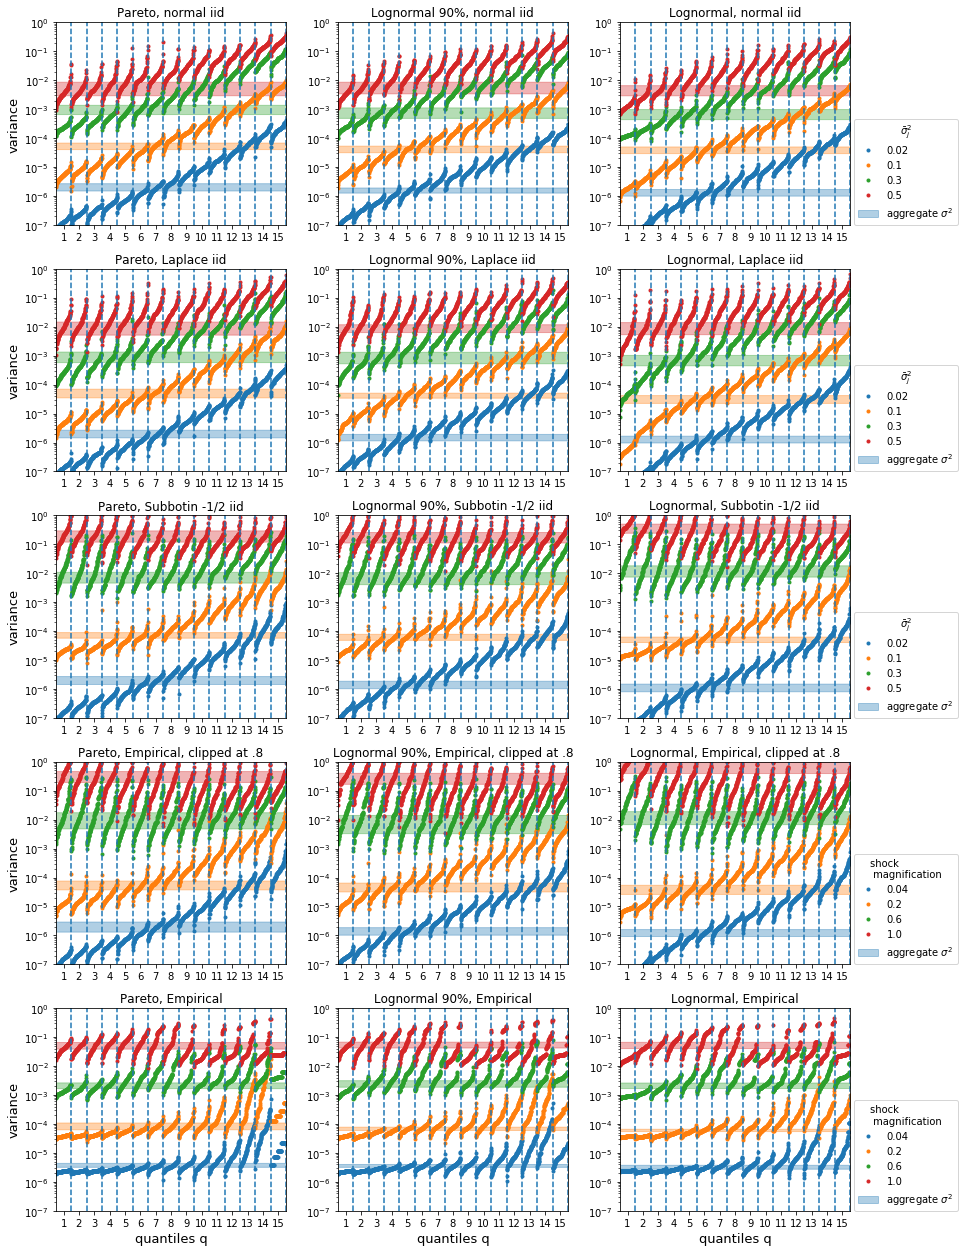

In [34]:
size_distributions = ['pareto', 'logn90', 'logn']
growth_rates = ['norm', 'lapl', 'sbtn', 'emp_szd_T16_clip.8','emp_szd_T16']
Q = 15

fig, axs = plt.subplots(len(growth_rates), len(size_distributions), figsize = (4.5*len(size_distributions), 3.5*len(growth_rates)))

size_names = ['Pareto', 'Lognormal 90%', 'Lognormal']
dist_names = ['normal iid', 'Laplace iid', 'Subbotin -1/2 iid','Empirical, clipped at .8', 'Empirical']
for i, sizes in enumerate(size_distributions):
    for j, dist in enumerate(growth_rates):
        ax = axs[j][i]
        ax.set_title(size_names[i] +', '+ dist_names[j])
        result = full_data.loc[(full_data.sizes == sizes) & (full_data.dist == dist)]
        result = result.loc[result.Q == Q]

        y = 'var_diff_qi'
        sorted_ = result.sort_values(by = ['dist','s', 'q', y])
        Ss = sorted_.s.unique()[::2]
        for k, s in enumerate(Ss):
            sorted_s = sorted_.loc[sorted_.s == s]
            sorted_s.reset_index()[[y]].plot(ax = ax, marker = '.', lw = 0, c = colors[k])
#                     sorted_s.reset_index()[['var_diff_agg_i']].plot(ax = ax, marker = '.', lw = 0, c = colors[k], alpha = .1, legend = False)
            agg_vals = sorted_s.reset_index()['var_diff_agg_i'].describe()
            ax.fill_between(range(len(sorted_s)), agg_vals['25%'], agg_vals['75%'], color = colors[k], alpha = .35, zorder = -1)
        
            ax.xaxis.set_ticks(np.arange(0, (Q)*100, 100) + 100/2)
            ax.xaxis.set_ticklabels(np.arange(Q) + 1)
            
        if i == len(size_distributions) - 1:
            if j <= 2: ax.legend([s for s in Ss]+[r'aggregate $\sigma^2$'], title=r'$\bar \sigma^2_j$', loc = (1.02, 0))
            if j > 2: ax.legend([str(2*s) for s in Ss]+[r'aggregate $\sigma^2$'], title='shock \n magnification', loc = (1.02, 0))        
        else:
            ax.get_legend().remove()

        [ax.axvline(l, linestyle = '--') for l in sorted_s.groupby(['q']).count().iloc[:, 0].cumsum().values]
        ax.set_yscale('log')
        ax.set_ylim(1e-7, 1)
        if i == 0: ax.set_ylabel('variance', fontsize = 13)
        if j == len(growth_rates) - 1: ax.set_xlabel('quantiles q', fontsize = 13)
        
plt.tight_layout()
plt.savefig('./../../../thesis_writing/figures/quantile_depce_supplement.png', dpi = 400)

plt.show()

In [282]:
# for i, sizes in enumerate(size_distributions):
#     for j, dist in enumerate(growth_rates):
#         print(sizes +', '+ dist)
#         display(data3[i][j].head())

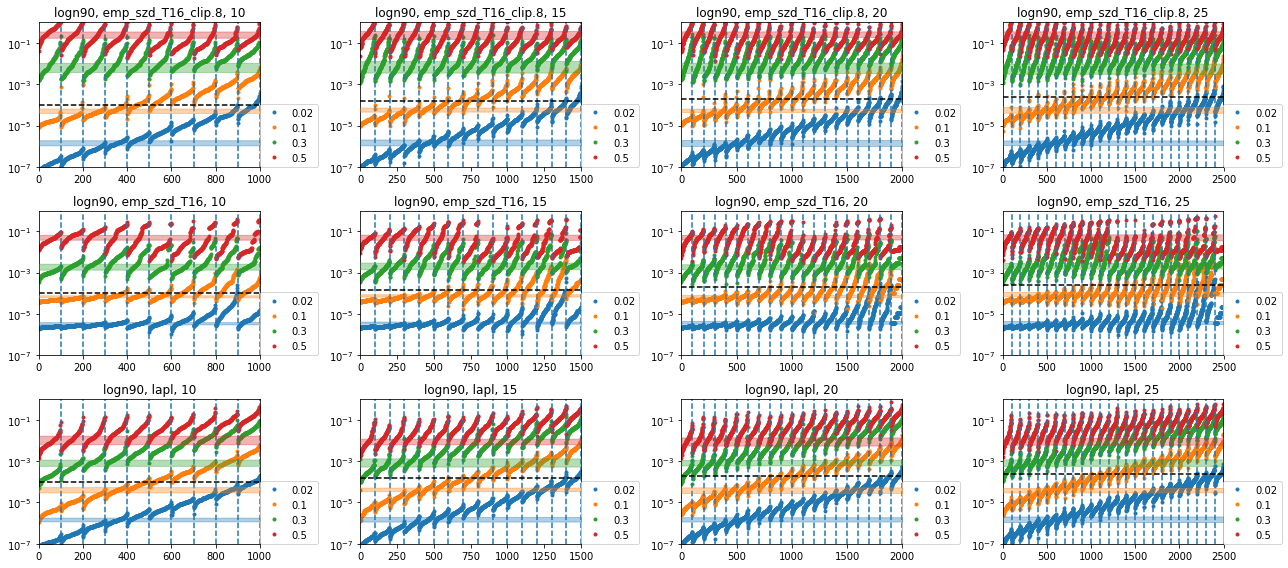

In [294]:
growth_rates = ['emp_szd_T16_clip.8', 'emp_szd_T16', 'lapl']
fig, axs = plt.subplots(len(growth_rates), 4, figsize = (18, 8))

sizes = 'logn90'
for i, dist in enumerate(growth_rates):
    result = full_data.loc[(full_data.sizes == sizes) & (full_data.dist == dist)]
    y = 'var_diff_qi'
    sorted_ = result.sort_values(by = ['dist','s', 'q', y])    
    for j, Q in enumerate(result.Q.unique()):
        ax = axs[i][j]
        ax.set_title(sizes +', '+ dist + ', '+ str(Q))
        
        sorted_Q = sorted_.loc[sorted_.Q == Q]
        Ss = sorted_.s.unique()[::2]
        for k, s in enumerate(Ss):
            sorted_s = sorted_Q.loc[sorted_Q.s == s]
            sorted_s.reset_index()[[y]].plot(ax = ax, marker = '.', lw = 0, c = colors[k])
#                     sorted_s.reset_index()[['var_diff_agg_i']].plot(ax = ax, marker = '.', lw = 0, c = colors[k], alpha = .1, legend = False)
            agg_vals = sorted_s.reset_index()['var_diff_agg_i'].describe()
            ax.fill_between(range(len(sorted_s)), agg_vals['25%'], agg_vals['75%'], color = colors[k], alpha = .35, zorder = 10)

        ax.legend(Ss, loc = (1, 0))
        [ax.axvline(l, linestyle = '--') for l in sorted_s.groupby(['q']).count().iloc[:, 0].cumsum().values]
        ax.axhline(Q/100000, linestyle = '--', c = 'k')
        ax.set_ylim(1e-7, 1)
        ax.set_yscale('log')

plt.tight_layout()


## Generate size distribution params

In [212]:
# Now we can have the n(Q, q)
def get_n(x1, Q):
    x_lin = np.power(10, x1)
    bins = pd.cut(pd.Series(np.cumsum(x_lin)), Q)
    ns = bins.value_counts().values
    return bins, ns

#  - Lognormal clipped x > 3. 
sigma = 1.2810683494198207 # 1.3149476902828778
mu = 4.536908110675739 # 4.470439741406725
# 13% of guys that would be below the .3 threshold.
z = (mu - 3)/sigma
cum_th = 1 - .5*(1 + erf(z/np.sqrt(2)))
# From the theoretical N and the ppf we can know the theoretical quantiles
N = int(1e5)
N_ = int(round(N/(1 - cum_th))) # We use a larger N ..
x_logn_clip3 = np.array([norm.ppf(q, mu, sigma) for q in np.arange(0, 1, 1/N_) + .5/N_])
x_logn_clip3 = x_logn_clip3[(-N - 1):-1]

## N tail for pareto and lognormal tail
N_tail = get_n(x_logn_clip3, 10)[1][1:].sum()
x_logn_clip3_90 = x_logn_clip3[-N_tail:]

# PARETO
z_0 = -1.1042021 #-1.1771
# value_qs_1 = x_logn_clip3_90.min() # 6.761 in the original fit
value_qs_1 = 6.67465

norm_const = 1.375
x1 = np.array([pareto.ppf(b = -z_0, scale = 10**value_qs_1, q = q) for q in np.arange(0, 1, 1/(norm_const*N_tail)) + .5/(norm_const*N_tail)])
np.log10(pareto.rvs(b = -z_0, size = N_tail, scale = 10**value_qs_1) + 1)
x1 = x1[int(-norm_const*N_tail - 1):-1]
x_pareto = np.log10(x1)

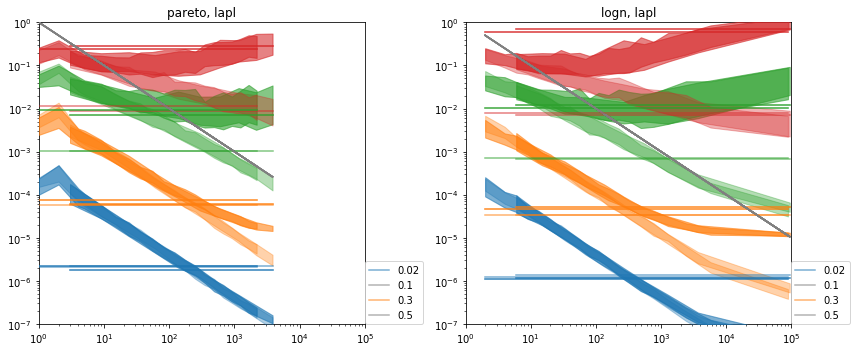

In [295]:
fig, axs = plt.subplots(1, 2, figsize = (12, 5))

# Q_ = 20
for Q_ in [10, 20]:
    for i, sizes in enumerate(['pareto', 'logn']):
        for j, dist in enumerate(['emp_szd_T16_clip.8','emp_szd_T16_clip.8', 'lapl']):
            ax = axs[i]
            ax.set_title(sizes +', '+ dist)
            result = full_data.loc[(full_data.sizes == sizes) & (full_data.dist == dist)]
            result = result.loc[result.Q == Q_]

            y = 'var_diff_qi'

            # Merge the Ns
            bins, ns = get_n([x_pareto, x_logn_clip3, x_logn_clip3_90][i], Q_)
            ns = pd.DataFrame([range(Q_), ns], index = ['q', 'n']).T
            result = result.merge(ns)
            result['log_n'] = np.log10(result.n)
    #         result['log_var_diff_qi'] = np.log10(result.var_diff_qi)

            sorted_ = result.sort_values(by = ['dist','s', 'q', y])
            Ss = sorted_.s.unique()[::2]
            for k, s in enumerate(Ss):
                sorted_s = sorted_.loc[sorted_.s == s]
    #             sorted_s.reset_index()[[y]].plot(ax = ax, marker = '.', lw = 0, c = colors[k])
    #                     sorted_s.reset_index()[['var_diff_agg_i']].plot(ax = ax, marker = '.', lw = 0, c = colors[k], alpha = .1, legend = False)
                agg_vals = sorted_s.reset_index()['var_diff_agg_i'].describe()
                bin_vals = sorted_s.groupby('n')['var_diff_qi'].describe()

                xn = bin_vals.index.values
                ax.plot([xn.min(), xn.max()], [agg_vals['50%'], agg_vals['50%']], color = colors[k], alpha = .6, zorder = 10)
                ax.plot([xn.min(), xn.max()], [1/xn.min(), 1/xn.max()], color = '.5', alpha = .6, zorder = 10)
                ax.fill_between(xn, bin_vals['25%'], bin_vals['75%'], color = colors[k], alpha = .35, zorder = 10)

            ax.legend(Ss, loc = (1, 0))
    #         [ax.axvline(l, linestyle = '--') for l in sorted_s.groupby(['q']).count().iloc[:, 0].cumsum().values]
            ax.set_xscale('log')
            ax.set_xlim(1, 1e5)

            ax.set_yscale('log')
            ax.set_ylim(1e-7, 1)

plt.tight_layout()


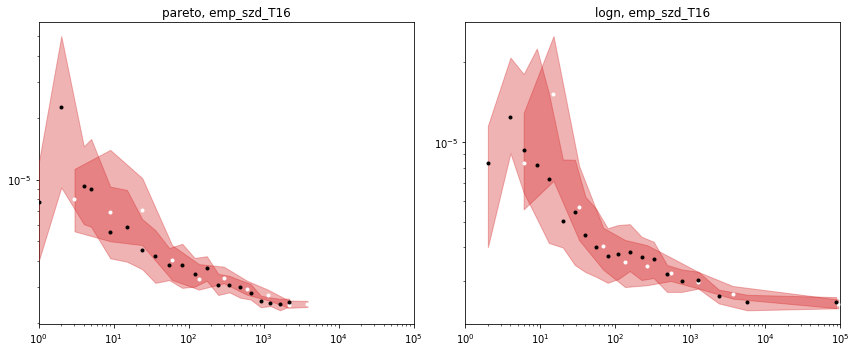

In [173]:
# Como se mueven Q y n al mismo tiempo. 
# En teoria esta bien, peor en la practica hay mucha volatilidad como para verlo lindo.

# fig, axs = plt.subplots(1, 2, figsize = (12, 5))

# # Q_ = 20
# for l, Q_ in enumerate([10, 20]):
#     for i, sizes in enumerate(['pareto', 'logn']):
#         for j, dist in enumerate(['emp_szd_T16']):
#             ax = axs[i]
#             ax.set_title(sizes +', '+ dist)
#             result = data2[i][j]
#             result = result.loc[result.Q == Q_]

#             y = 'var_diff_qi'

#             # Merge the Ns
#             bins, ns = get_n([x_pareto, x_logn_clip3, x_logn_clip3_90][i], Q_)
#             ns = pd.DataFrame([range(Q_), ns], index = ['q', 'n']).T
#             result = result.merge(ns)
#             result['log_n'] = np.log10(result.n)
#     #         result['log_var_diff_qi'] = np.log10(result.var_diff_qi)

#             sorted_ = result.sort_values(by = ['dist','s', 'q', y])
#             s = sorted_.s.unique()[0]
            
#             sorted_s = sorted_.loc[sorted_.s == s]
# #             sorted_s.reset_index()[[y]].plot(ax = ax, marker = '.', lw = 0, c = colors[k])
# #                     sorted_s.reset_index()[['var_diff_agg_i']].plot(ax = ax, marker = '.', lw = 0, c = colors[k], alpha = .1, legend = False)
#             agg_vals = sorted_s.reset_index()['var_diff_agg_i'].describe()
#             bin_vals = sorted_s.groupby('n')['var_diff_qi'].describe()

#             xn = bin_vals.index.values
# #             ax.plot([xn.min(), xn.max()], [agg_vals['50%'], agg_vals['50%']], color = colors[k], alpha = .6, zorder = 10)
# #             ax.plot([xn.min(), xn.max()], [1/xn.min(), 1/xn.max()], color = '.5', alpha = .6, zorder = 10)
#             ax.fill_between(xn, bin_vals['25%'], bin_vals['75%'], color = colors[k], alpha = .35, zorder = 10)
#             ax.plot(xn, bin_vals['50%'], color = ['w','k'][l], zorder = 10, marker = '.', lw = 0)

# #             ax.legend(Qs, loc = (1, 0))
#     #         [ax.axvline(l, linestyle = '--') for l in sorted_s.groupby(['q']).count().iloc[:, 0].cumsum().values]
#             ax.set_xscale('log')
#             ax.set_xlim(1, 1e5)

#             ax.set_yscale('log')
# #             ax.set_ylim(1e-7, 1)

# plt.tight_layout()


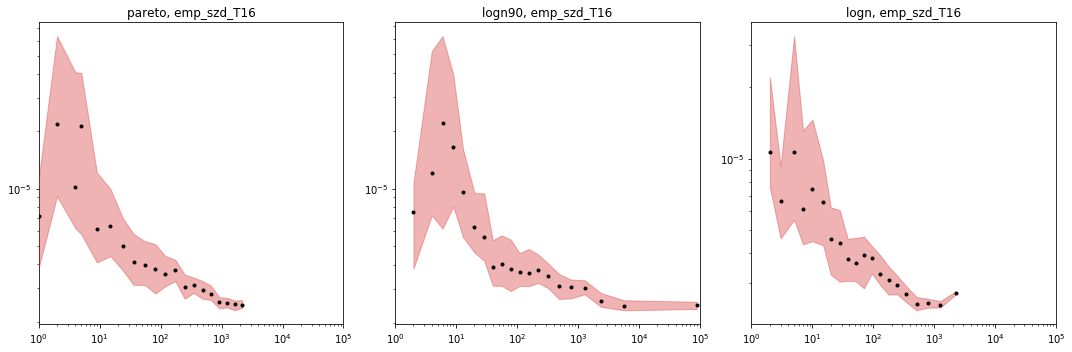

In [296]:
# Como se mueven Q y n al mismo tiempo. 
# En teoria esta bien, peor en la practica hay mucha volatilidad como para verlo lindo.


fig, axs = plt.subplots(1, 3, figsize = (15, 5))
    
for i, sizes in enumerate(['pareto', 'logn90', 'logn']):
    for j, dist in enumerate(['emp_szd_T16']):
        ax = axs[i]
        ax.set_title(sizes +', '+ dist)
        result = full_data.loc[(full_data.sizes == sizes) & (full_data.dist == dist)]
        result = result.loc[result.Q == 20]

        y = 'var_diff_qi'

        # Merge the Ns
        bins, ns = get_n([x_pareto, x_logn_clip3, x_logn_clip3_90][i], Q_)
        ns = pd.DataFrame([range(Q_), ns], index = ['q', 'n']).T
        result = result.merge(ns)
        result['log_n'] = np.log10(result.n)
#         result['log_var_diff_qi'] = np.log10(result.var_diff_qi)

        sorted_ = result.sort_values(by = ['dist','s', 'q', y])
        s = sorted_.s.unique()[0]

        sorted_s = sorted_.loc[sorted_.s == s]
#             sorted_s.reset_index()[[y]].plot(ax = ax, marker = '.', lw = 0, c = colors[k])
#                     sorted_s.reset_index()[['var_diff_agg_i']].plot(ax = ax, marker = '.', lw = 0, c = colors[k], alpha = .1, legend = False)
        agg_vals = sorted_s.reset_index()['var_diff_agg_i'].describe()
        bin_vals = sorted_s.groupby('n')['var_diff_qi'].describe()

        xn = bin_vals.index.values
#             ax.plot([xn.min(), xn.max()], [agg_vals['50%'], agg_vals['50%']], color = colors[k], alpha = .6, zorder = 10)
#             ax.plot([xn.min(), xn.max()], [1/xn.min(), 1/xn.max()], color = '.5', alpha = .6, zorder = 10)
        ax.fill_between(xn, bin_vals['25%'], bin_vals['75%'], color = colors[k], alpha = .35, zorder = 10)
        ax.plot(xn, bin_vals['50%'], color = 'k', zorder = 10, marker = '.', lw = 0)

#             ax.legend(Qs, loc = (1, 0))
#         [ax.axvline(l, linestyle = '--') for l in sorted_s.groupby(['q']).count().iloc[:, 0].cumsum().values]
        ax.set_xscale('log')
        ax.set_xlim(1, 1e5)

        ax.set_yscale('log')
#             ax.set_ylim(1e-7, 1)

plt.tight_layout()


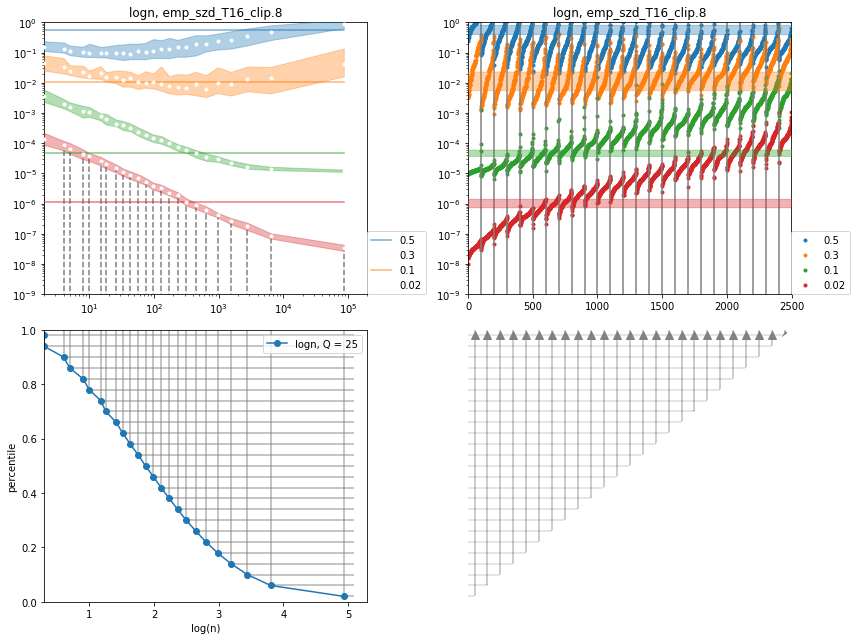

In [299]:
### Superplot

# Choose 
#  - size dist
#  - growth rates
#  - Q

Q_ = 25;

i = 1
j = 0
sizes = ['pareto', 'logn', 'logn90'][i]
x1 = [x_pareto, x_logn_clip3, x_logn_clip3_90][i]
dist = ['emp_szd_T16_clip.8','emp_szd_T16', 'lapl', 'norm'][j]


result = full_data.loc[(full_data.sizes == sizes) & (full_data.dist == dist)]
result = result.loc[result.Q == Q_]

fig, axs = plt.subplots(2, 2, figsize = (12, 9))


##########
# PLOT 1 #
##########

ax = axs[0][0]
ax.set_title(sizes +', '+ dist)

y = 'var_diff_qi'

# Merge the Ns
bins, ns = get_n(x1, Q_)
ns = pd.DataFrame([range(Q_), ns], index = ['q', 'n']).T
result = result.merge(ns)
result['log_n'] = np.log10(result.n)

sorted_ = result.sort_values(by = ['dist','s', 'q', y])

Ss = sorted_.s.unique()[::-2]
for k, s in enumerate(Ss):
    sorted_s = sorted_.loc[sorted_.s == s]
    agg_vals = sorted_s.reset_index()['var_diff_agg_i'].describe()
    bin_vals = sorted_s.groupby('n')['var_diff_qi'].describe()

    xn = bin_vals.index.values
    ax.plot([xn.min(), xn.max()], [agg_vals['50%'], agg_vals['50%']], color = colors[k], alpha = .6, zorder = 10)
    ax.fill_between(xn, bin_vals['25%'], bin_vals['75%'], color = colors[k], alpha = .35, zorder = 10)
    ax.plot(xn, bin_vals['50%'], color = 'w', zorder = 10, marker = '.', lw = 0)

markerline, stemlines, baseline = ax.stem(xn, bin_vals['50%'], '.5', markerfmt = 'None', bottom = 0)
plt.setp(stemlines, 'linestyle', 'dashed')

ax.legend(Ss, loc = (1, 0))
ax.set_xscale('log')
ax.set_xlim(2, 2e5)
ax.set_yscale('log')
ax.set_ylim(1e-9, 1)


##########
# PLOT 2 #
##########

ax = axs[1][0]
# for i, Q in enumerate([10, 20, 30]):
#     ns = get_n(x_pareto, Q)[1]
#     ax.plot(np.log10(ns), .1 + 0.9*(np.arange(Q)/Q), marker = '.', c = '#ff7f0e', alpha = [1, .8, .6][i], label = 'Pareto, Q = '+str(Q))
    
# for i, Q in enumerate([10, 20, 30]):
Q = Q_
ns = get_n(x1, Q)[1]
pct_levels = (np.arange(Q) + .5)/Q
ax.plot(np.log10(ns), pct_levels, marker = 'o', c = '#1f77b4', label = sizes + ', Q = '+str(Q))
# ax.stem(np.log10(ns), pct_levels, '.5', markerfmt = 'None', bottom = 1)
ax.hlines(pct_levels, 5.1, np.log10(ns), color='.5', alpha = .6)
ax.vlines(np.log10(ns), 1, pct_levels, color='.5', alpha = .6)

ax.set_ylabel('percentile')
ax.set_xlabel('log(n)')
ax.set_ylim(0, 1)
ax.set_xlim(np.log10(2), np.log10(2e5))
ax.legend()


##########
# PLOT 3 #
##########

ax = axs[1][1]
Q = Q_
pct_levels = (np.arange(Q) + .5)/Q
plot_levels_reflex(pct_levels, ax)
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)


##########
# PLOT 4 #
##########

ax = axs[0][1]
ax.set_title(sizes +', '+ dist)

for k, s in enumerate(Ss):
    sorted_s = sorted_.loc[sorted_.s == s]
    sorted_s.reset_index()[[y]].plot(ax = ax, marker = '.', lw = 0, c = colors[k])
#                     sorted_s.reset_index()[['var_diff_agg_i']].plot(ax = ax, marker = '.', lw = 0, c = colors[k], alpha = .1, legend = False)
    agg_vals = sorted_s.reset_index()['var_diff_agg_i'].describe()
    ax.fill_between(range(len(sorted_s)), agg_vals['25%'], agg_vals['75%'], color = colors[k], alpha = .35, zorder = 10)
    

[ax.axvline(l, color = '.5') for l in sorted_s.groupby(['q']).count().iloc[:, 0].cumsum().values]
ax.set_yscale('log')
ax.set_ylim(1e-9, 1)
ax.legend(Ss, loc = (1, 0))

# plt.savefig('./../../../thesis_writing/figures/quantile_logn.png', dpi = 400)
plt.tight_layout()
plt.show()


## Older

In [300]:
xx

NameError: name 'xx' is not defined

In [43]:

ax = axs[1][0]
# for i, Q in enumerate([10, 20, 30]):
#     ns = get_n(x_pareto, Q)[1]
#     ax.plot(np.log10(ns), .1 + 0.9*(np.arange(Q)/Q), marker = '.', c = '#ff7f0e', alpha = [1, .8, .6][i], label = 'Pareto, Q = '+str(Q))
    
for i, Q in enumerate([10, 20, 30]):
    ns = get_n(x_logn_clip3, Q)[1]
    ax.plot(np.log10(ns), np.arange(Q)/Q, marker = '.', c = '#1f77b4', alpha = [1, .8, .6][i], label = 'Lognormal, Q = '+str(Q))

ax.set_ylabel('percentile')
ax.set_xlabel('log(n)')
ax.set_ylim(0, 1)
ax.set_xlim(np.log10(2), np.log10(2e5))
ax.legend()
# plt.savefig('./../../../thesis_writing/figures/quantile_logn.png', dpi = 400)

plt.tight_layout()
plt.show()

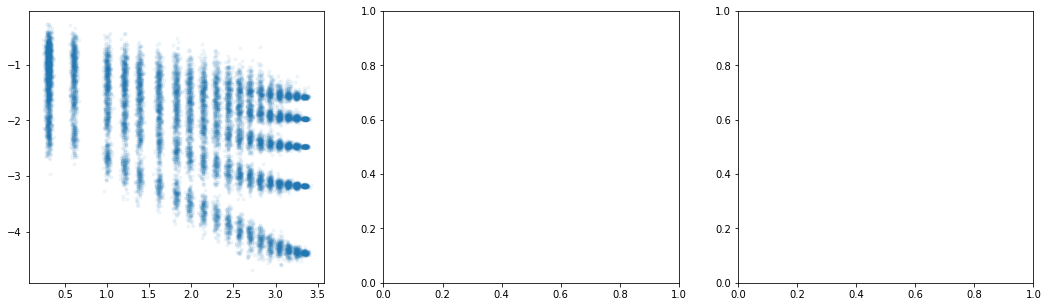

In [53]:
# Load
results = []
for j, x1 in enumerate([x_pareto, x_logn_clip3]):
    sizes = ['pareto', 'logn90', 'logn'][j]
    for k, dist in enumerate(['sbtn', 'lapl', 'norm']):        
        filename = './../../data/processed/exp_var_'+dist+'_1s_'+sizes+'.csv'
        results += [pd.read_csv(filename)]

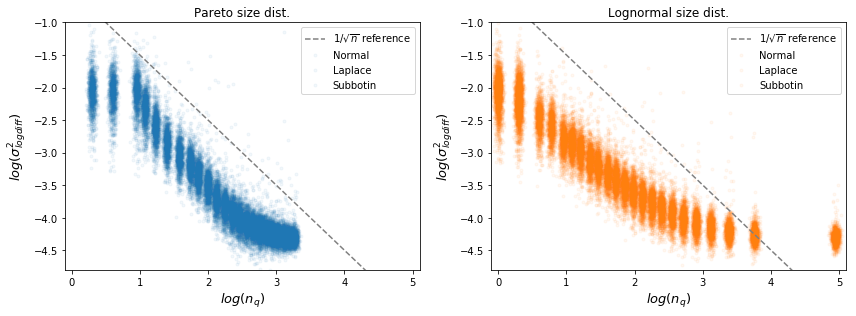

In [112]:
fig, axs = plt.subplots(1, 2, figsize = (12, 4.5))

Q_ = 25
s = .1

for j, x1 in enumerate([x_pareto, x_logn_clip3]):
    N = len(x1)
    sizes = ['pareto', 'logn'][j]
    for k, dist in enumerate(['sbtn', 'lapl', 'norm']):
        ax = axs[j]
        df = results[3*j + k][['Q','q', 'var_diff_qi','s']]
        df = df.loc[(df.Q == Q_) & (df.s == s)]
        df['t'] = df['var_diff_qi']/(df['s']**2)
        bins, ns = get_n(x1, Q_)
        ns = pd.DataFrame([range(Q_), ns], index = ['q', 'n']).T
        df = df.merge(ns)
        df['log_n'] = np.log10(df.n)
        df['log_var_diff_qi'] = np.log10(df.var_diff_qi)

        frac = 1; alpha = .05
#         frac = .1; alpha = .5
        data=df.sample(frac = frac); data.log_n = data.log_n + np.random.normal(0, 0.03, len(data))
        ax.scatter(x=data.log_n.values, y=data.log_var_diff_qi.values, alpha = alpha, marker = '.', 
                   label = ['Normal', 'Laplace', 'Subbotin'][k], color = ['#1f77b4', '#ff7f0e'][j])
        ax.set_title(['Pareto', 'Lognormal'][j]+' size dist.')
        ax.set_xlabel(r'$log(n_q)$', fontsize = 13)
        ax.set_ylabel(r'$log(\sigma^2_{logdiff})$', fontsize = 13)
        ax.set_xlim(-0.1, 5.1)
        ax.set_ylim(-4.8, -1)
        x_ = np.arange(0, 6, 1)
    ax.plot(x_, -x_-.5, linestyle = '--', color = '.5', label = r'$1/\sqrt{n}$ reference')
    ax.legend()
        
plt.tight_layout()
plt.savefig('./../../../thesis_writing/figures/sigma_logn_sizedist.png', dpi = 400)
plt.show()
# colors:
# ['#1f77b4',
#  '#ff7f0e']

#         y = 't'
#         sorted_ = result.sort_values(by = ['dist','s', 'q', y])
#         [ax.axvline(l, linestyle = '--') for l in sorted_.groupby(['dist','s', 'q']).count().iloc[:, 0].cumsum().values]
#         [ax.axvline(l, lw = 2) for l in sorted_.groupby(['s','Q']).count().iloc[:, 0].cumsum().values]
#         sorted_.reset_index()[[y]].plot(ax = ax, marker = '.', lw = 0)
#         ax.set_yscale('log')

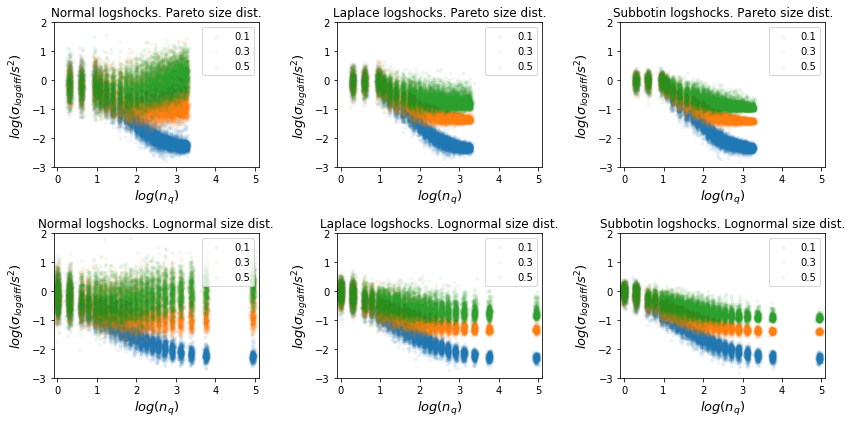

In [109]:
fig, axs = plt.subplots(2, 3, figsize = (12, 6))

Q_ = 25

for j, x1 in enumerate([x_pareto, x_logn_clip3]):
# for j, x1 in enumerate([x_logn_clip3]):
    N = len(x1)
    sizes = ['pareto', 'logn'][j]
    for k, dist in enumerate(['sbtn', 'lapl', 'norm']):
        ax = axs[j][k]
        df = results[3*j + k][['Q','q', 'var_diff_qi','s']]
        df = df.loc[(df.Q == Q_)]
        df['t'] = df['var_diff_qi']/(df['s']**2)
        bins, ns = get_n(x1, Q_)
        ns = pd.DataFrame([range(Q_), ns], index = ['q', 'n']).T
        df = df.merge(ns)
        df['log_n'] = np.log10(df.n)

        frac = 1; alpha = .05
        for s in [.1, .3, .5]:
            df['log_var_diff_qi'] = np.log10(df.var_diff_qi) - np.log10(s**2)
            data = df[df.s == s].sample(frac = frac); data.log_n = data.log_n + np.random.normal(0, 0.03, len(data))
            ax.scatter(x=data.log_n.values, y=data.log_var_diff_qi.values, alpha = alpha, marker = '.', label = str(s))
        ax.set_title(['Normal', 'Laplace', 'Subbotin'][k]+' logshocks. '+['Pareto', 'Lognormal'][j]+' size dist.')
        ax.legend()
        ax.set_xlabel(r'$log(n_q)$', fontsize = 13)
        ax.set_ylabel(r'$log(\sigma_{logdiff} / s^2)$', fontsize = 13)
        ax.set_xlim(-0.1, 5.1)
        ax.set_ylim(-3, 2)
        
plt.tight_layout()
plt.savefig('./../../../thesis_writing/figures/sigma_logn_s.png', dpi = 400)
plt.show()


In [ ]:
['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']